### Extract target answer type

In [1]:
import torch
from langchain.prompts import PromptTemplate
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import warnings
warnings.filterwarnings("ignore")

In [2]:
# examples extracted from train
class baseline_LLM:
    def __init__(self, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForCausalLM.from_pretrained(model_path,
                                                          device_map="auto",
                                                          torch_dtype=torch.bfloat16)
        self.template ="""
You are tasked to extract the answer entity type corresponding to a question.

Here are some examples:
who wrote films that share actors with the film [Anastasia] => writer
which person directed the films acted by the actors in [Jawbreaker] => director
what languages are the films that share directors with [The Age of Innocence] in => language
who starred in the films whose directors also directed [The Decline of the American Empire] => actor
when did the movies release whose actors also appear in the movie [Little Big Man] => year
which person wrote the movies directed by the director of [Incognito] => writer
who are the directors of the movies written by the writer of [The Green Mile] => director
what types are the films directed by the director of [The Conspirator] => genre
what genres are the movies written by [The Beast] writers => genre
who acted in the films directed by the director of [Terms of Endearment] => actor
the films that share actors with the film [Dil Chahta Hai] were released in which years => year
the movies written by the screenwriter of [The Science of Sleep] starred who => actor
who directed the movies written by the writer of [A Sunday in the Country] => director
the films written by the screenwriter of [Dracula 2000] were directed by who => director
who is listed as director of the movies starred by [Our Modern Maidens] actors => director
when did the movies written by [Europa] writers release => year
what types are the movies written by the writer of [The Green Hornet] => genre

No explanation required. Output one of: 'actor', 'director', 'genre', 'language', 'writer', 'year'.

{question} =>
"""
        self.prompt_template = PromptTemplate.from_template(self.template)

    def predict(self, question):
        formatted_prompt = self.prompt_template.format(question = question)

        chat = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": formatted_prompt},
        ]

        tokenized_chat = self.tokenizer.apply_chat_template(chat, tokenize=True, add_generation_prompt=True, return_tensors="pt").to(device)

        outputs = self.model.generate(tokenized_chat, max_new_tokens=100, pad_token_id=self.tokenizer.eos_token_id).cpu()
        tokenized_chat = tokenized_chat.cpu() ###
        del tokenized_chat ###

        return self.tokenizer.decode(outputs[0]).split("<|end_header_id|>")[-1].strip().split("<|eot_id|>")[0]

In [3]:
# load model
llm = baseline_LLM("/scratch/users/nus/e1329380/models/models--meta-llama--Llama-3.1-8B-Instruct/snapshots/0e9e39f249a16976918f6564b8830bc894c89659/")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
# testing
qn = "the films that share actors with the film [Dil Chahta Hai] were released in which years"
llm.predict(qn)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


'year'

In [5]:
# iterate through train (first 5000)
df = pd.read_csv('../Datasets/MetaQA_dataset/vanilla 3-hop/qa_train.txt', sep='\t', header=None, names=['question', 'answer'])
with open('../Datasets/MetaQA_dataset/processed/train_ans_type.txt', 'w') as f:
    for idx in tqdm(range(5000)):
        f.write(llm.predict(df.question.iloc[idx]))
        f.write("\n")

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [06:17<00:00, 13.25it/s]


In [6]:
# check against groundtruth
gt_types = []
with open('../Datasets/MetaQA_dataset/vanilla 3-hop/qa_train_qtype.txt') as f:
    for line in f:
        gt_types.append(line.strip().split("_")[-1])
gt_types = gt_types[:5000]

pred_types = []
with open('../Datasets/MetaQA_dataset/processed/train_ans_type.txt') as f:
    for line in f:
        if line:
            pred_types.append(line.strip())

In [13]:
# sanity check
sum([1 for (i, j) in zip(gt_types, pred_types) if i!=j])

0

In [9]:
# iterate through train (first 1000)
df = pd.read_csv('../Datasets/MetaQA_dataset/vanilla 3-hop/qa_dev.txt', sep='\t', header=None, names=['question', 'answer'])
with open('../Datasets/MetaQA_dataset/processed/dev_ans_type.txt', 'w') as f:
    for idx in tqdm(range(1000)):
        f.write(llm.predict(df.question.iloc[idx]))
        f.write("\n")

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:15<00:00, 13.26it/s]


In [14]:
# check against groundtruth
gt_types = []
with open('../Datasets/MetaQA_dataset/vanilla 3-hop/qa_dev_qtype.txt') as f:
    for line in f:
        gt_types.append(line.strip().split("_")[-1])

pred_types = []
with open('../Datasets/MetaQA_dataset/processed/dev_ans_type.txt') as f:
    for line in f:
        if line:
            pred_types.append(line.strip())

In [15]:
# sanity check
sum([1 for (i, j) in zip(gt_types, pred_types) if i!=j])

0

In [10]:
# iterate through train (first 1000)
df = pd.read_csv('../Datasets/MetaQA_dataset/vanilla 3-hop/qa_test.txt', sep='\t', header=None, names=['question', 'answer'])
with open('../Datasets/MetaQA_dataset/processed/test_ans_type.txt', 'w') as f:
    for idx in tqdm(range(1000)):
        f.write(llm.predict(df.question.iloc[idx]))
        f.write("\n")

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:15<00:00, 13.25it/s]


In [16]:
# check against groundtruth
gt_types = []
with open('../Datasets/MetaQA_dataset/vanilla 3-hop/qa_test_qtype.txt') as f:
    for line in f:
        gt_types.append(line.strip().split("_")[-1])

pred_types = []
with open('../Datasets/MetaQA_dataset/processed/test_ans_type.txt') as f:
    for line in f:
        if line:
            pred_types.append(line.strip())

In [17]:
# sanity check
sum([1 for (i, j) in zip(gt_types, pred_types) if i!=j])

0

### Extract node entity type

In [42]:
from functions_modified import *
from torch.utils.data import DataLoader

path_to_node_embed = '../Datasets/MetaQA_dataset/processed/node2vec _embeddings/ud_node2vec_embeddings.txt'
path_to_idxes = '../Datasets/MetaQA_dataset/processed/idxes.json'
path_to_qa = '../Datasets/MetaQA_dataset/vanilla 3-hop/qa_train.txt'
path_to_ans_types = '../Datasets/MetaQA_dataset/processed/train_ans_type.txt'
data = KGQADataset(path_to_node_embed, path_to_idxes, path_to_qa, path_to_ans_types, train = True)

dataloader = DataLoader(data, batch_size=16, collate_fn=collate_fn, shuffle=True)

for batched_subgraphs, question_embeddings, stacked_labels, node_maps, labels, answer_types in dataloader:
    break

In [74]:
i = 7
sum(np.array(labels[i])[np.where(np.array(batched_subgraphs[i].node_types) == answer_types[i])[0]])

9

In [75]:
sum(labels[i])

tensor(9)

In [76]:
# total nodes to calculate loss on or evaluate metric on
len(np.array(labels[i])[np.where(np.array(batched_subgraphs[i].node_types) == answer_types[i])[0]])

21

In [77]:
answer_types[i]

'genre'

In [84]:
type(batched_subgraphs.node_types)

list

### Test and understand extract node embedding

In [42]:
from extract_node_embed import *
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import subgraph, to_networkx
import torch
from torch_geometric.data import Data

In [2]:
def extract_entity_from_question(question):
    """
    Extract the entity that is enclosed in square brackets from the question.
    Example: "What city is [Paris] the capital of?" -> "Paris"
    """
    # assumes one entity of interest in each questin
    start = question.find('[') + 1
    end = question.find(']')
    if start == 0 or end == -1:
        raise ValueError(f"No entity found in the question: {question}")
    return question[start:end]

In [5]:
path_to_qa = '../Datasets/MetaQA_dataset/vanilla 2-hop/qa_train.txt'
qa_df = pd.read_csv(path_to_qa, sep='\t', header=None, names=['question', 'answer'])
G = generate_nx_graph('../Datasets/MetaQA_dataset/')
q_embeddings = model.encode([q.replace("[", "").replace("]", "") for q in qa_df['question'][:5000]], batch_size=128, convert_to_tensor=True) # 32
qa_df['query_entity'] = qa_df['question'].apply(extract_entity_from_question) # similar to the one in functions.py
query_entities = qa_df['query_entity'].tolist()

In [6]:
i = 25
entity = query_entities[i]
embedding = q_embeddings[i]
result = find_best_embedding(G, entity, embedding)

In [7]:
qa_df['answer'][i], qa_df['question'][i], entity, len(result.keys()), result.keys()

('Drama|Comedy|Music',
 'what genres are the films acted by [Dina Korzun] in',
 'Dina Korzun',
 20,
 dict_keys(['2009', 'Comedy', 'Drama', 'Paul Giamatti', 'Sophie Barthes', 'emily watson', 'paul giamatti', '2005', 'Darren E. Burrows', 'Ira Sachs', 'Music', 'Rip Torn', 'ira sachs', '2000', 'Artyom Strelnikov', 'Paddy Considine', 'Pawel Pawlikowski', 'Cold Souls', 'Forty Shades of Blue', 'Last Resort']))

In [8]:
find_paths(G, entity, 1)

[[('Dina Korzun', 'starring'), ('Cold Souls', None)],
 [('Dina Korzun', 'starring'), ('Forty Shades of Blue', None)],
 [('Dina Korzun', 'starring'), ('Last Resort', None)]]

In [9]:
find_paths(G, entity, 2)

[[('Dina Korzun', 'starring'), ('Cold Souls', 'release year'), ('2009', None)],
 [('Dina Korzun', 'starring'), ('Cold Souls', 'has genre'), ('Comedy', None)],
 [('Dina Korzun', 'starring'), ('Cold Souls', 'has genre'), ('Drama', None)],
 [('Dina Korzun', 'starring'),
  ('Cold Souls', 'starred actors'),
  ('Paul Giamatti', None)],
 [('Dina Korzun', 'starring'),
  ('Cold Souls', 'directed by and written by'),
  ('Sophie Barthes', None)],
 [('Dina Korzun', 'starring'),
  ('Cold Souls', 'has tags'),
  ('emily watson', None)],
 [('Dina Korzun', 'starring'),
  ('Cold Souls', 'has tags'),
  ('paul giamatti', None)],
 [('Dina Korzun', 'starring'),
  ('Forty Shades of Blue', 'release year'),
  ('2005', None)],
 [('Dina Korzun', 'starring'),
  ('Forty Shades of Blue', 'starred actors'),
  ('Darren E. Burrows', None)],
 [('Dina Korzun', 'starring'),
  ('Forty Shades of Blue', 'directed by and written by'),
  ('Ira Sachs', None)],
 [('Dina Korzun', 'starring'),
  ('Forty Shades of Blue', 'has genr

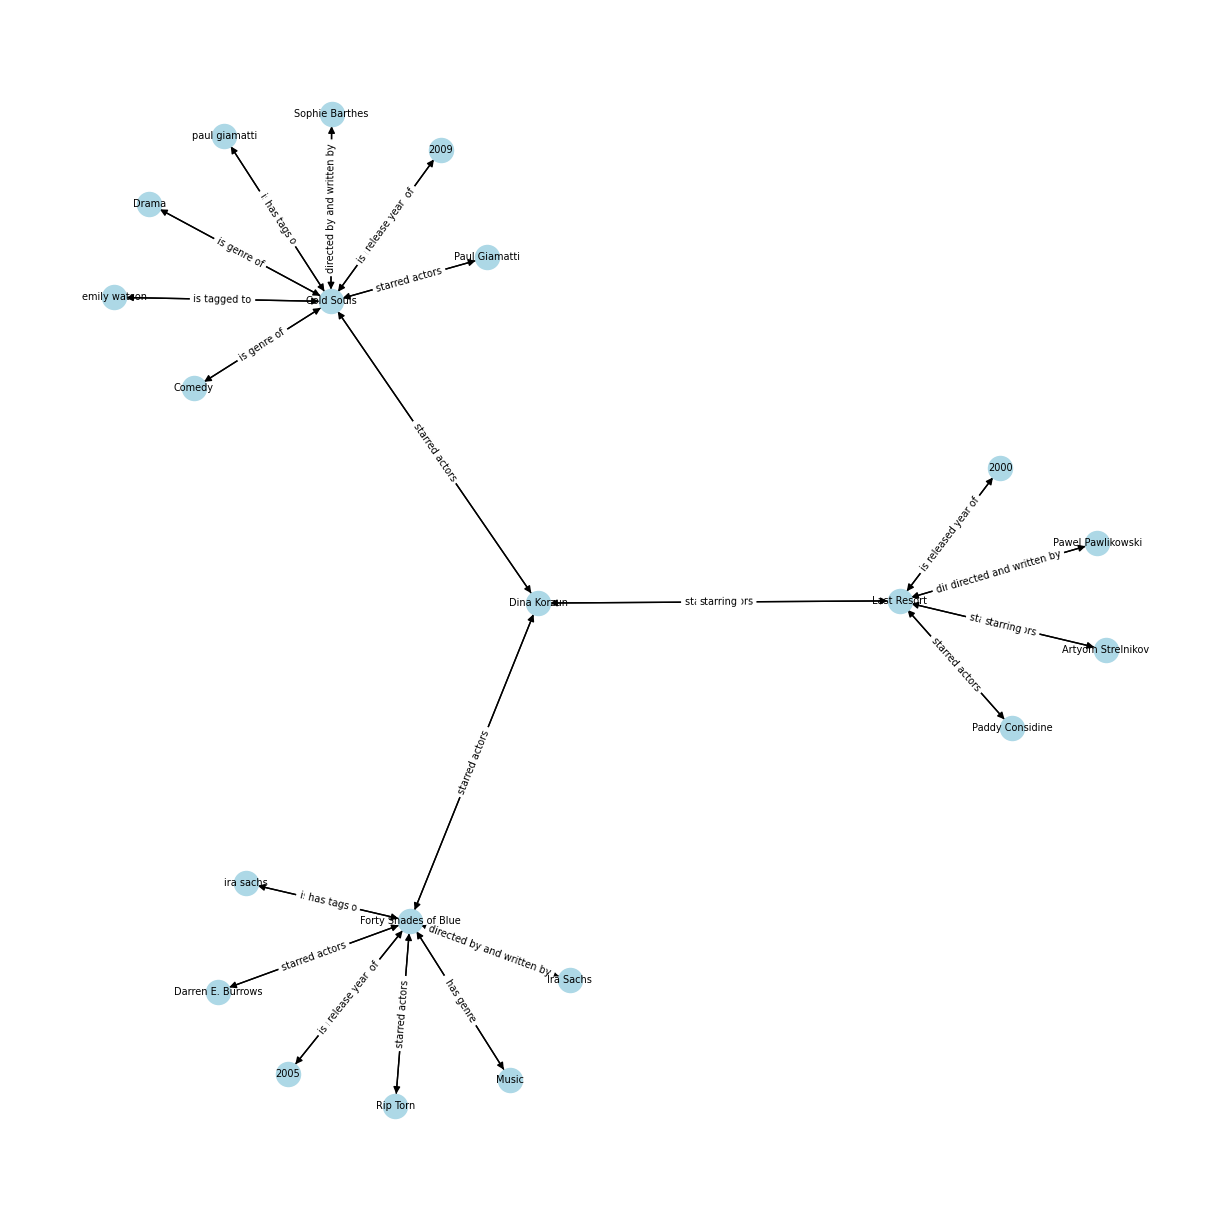

In [10]:
# just visualise subgraph
H = nx.subgraph(G, list(result.keys())+[entity])

plt.figure(1,figsize=(12,12))
pos = nx.spring_layout(H)
nx.draw(H, pos, with_labels=True, node_color='lightblue', font_size = 7)
# node_labels = nx.get_node_attributes(H,'state')
# nx.draw_networkx_labels(G, pos, labels = node_labels)
# nx.draw(H, with_labels=True, node_color='lightblue', font_size = 5, node_size=200)
edge_labels = nx.get_edge_attributes(H, 'relation')
nx.draw_networkx_edge_labels(H, pos, edge_labels = edge_labels, font_size = 7)
plt.show()

In [34]:
# generate full KG
G = generate_nx_graph('../Datasets/MetaQA_dataset/')
relations = [data['relation'] for _,_,data in G.edges(data=True)]
relation_mapping = {relation: int(index) for index, relation in enumerate(set(relations))}

# get node names
id_to_node = {}
node_to_id = {}
for i, n in enumerate(list(G.nodes)):
    id_to_node[i] = n
    node_to_id[n] = i

# create pytorch geometric graph
pyg_graph = from_networkx(G)
pyg_graph.edge_attr = torch.tensor([relation_mapping[r] for r in relations])

# get subgraph for each query
i = 25
entity = query_entities[i]
embedding = q_embeddings[i]
result = find_best_embedding(G, entity, embedding)
subset_nodes = [node_to_id[e] for e in list(result.keys())+[entity]]
query_edge_index, query_edge_attr = subgraph(subset = subset_nodes, edge_index = pyg_graph.edge_index, edge_attr = pyg_graph.edge_attr, relabel_nodes=True)
old_to_new = {}
new_to_old = {}
for new_idx, old_idx in enumerate(subset_nodes):
    old_to_new[old_idx] = new_idx
    new_to_old[new_idx] = old_idx
subgraph_data = Data(edge_index=query_edge_index, edge_attr=query_edge_attr)

# get node embeddings for subgraph
node_embeddings = []
for i in range(subgraph_data.num_nodes):
    ent = id_to_node[new_to_old[i]]
    if ent == entity:
        node_embeddings.append(embedding)
    else:
        node_embeddings.append(result[ent])
subgraph_data.x = torch.stack(node_embeddings)

/scratch/users/nus/e1329380/conda/gnn/lib/python3.8/site-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [36]:
subgraph_data.x.shape

torch.Size([21, 384])

In [37]:
subgraph_data.edge_index.shape

torch.Size([2, 40])

In [39]:
subgraph_data.edge_attr.shape

torch.Size([40])

In [40]:
subgraph_data.num_nodes

21

In [52]:
id_to_node[new_to_old[17]]

'Cold Souls'

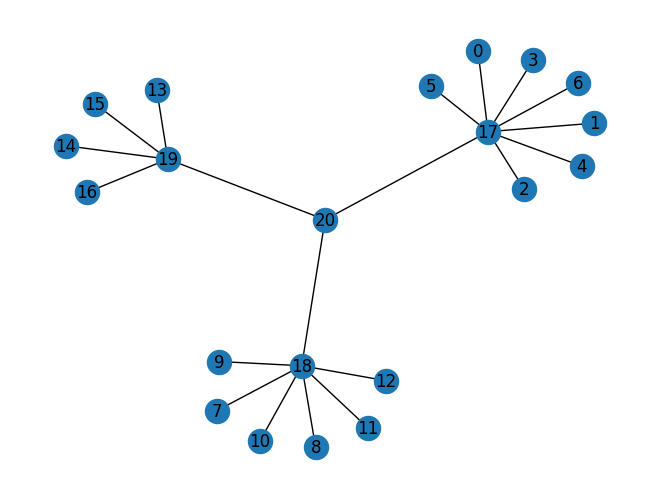

In [44]:
# confirming got the right graph
temp = to_networkx(subgraph_data, to_undirected=True)
nx.draw(temp, with_labels=True)

### Test kgqa_dataset.py

In [1]:
import sys
sys.path.append("/scratch/users/nus/e1329380/cs5284/QA_graph/GNN-cluster/src/datasets/")
from kgqa_dataset import *
from data_utils import *
from torch.utils.data import DataLoader

In [2]:
dataset = KGQADataset(None, None, "/scratch/users/nus/e1329380/cs5284/QA_graph/GNN-cluster/data/raw/2-hop/qa_train.txt", "/scratch/users/nus/e1329380/cs5284/QA_graph/GNN-cluster/data/raw/kb.txt", True)

In [3]:
data_loader = DataLoader(
    dataset,
    batch_size=32,
    collate_fn=collate_fn,
    shuffle=True
)

In [4]:
for batched_subgraphs, question_embeddings, stacked_labels, _, labels in data_loader:
    break

/scratch/users/nus/e1329380/conda/gnn/lib/python3.8/site-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


['Glenn Ford', 'Gene Nelson', "Maureen O'Hara", 'Robert Young', 'Robert Flemyng', 'Charlotte Greenwood', 'Olivia de Havilland', 'Frank Sinatra', 'Clifton Webb', 'Humphrey Bogart', 'Gordon MacRae', 'Richard Widmark', 'Robert Mitchum', 'Robert Ryan', 'Melvyn Douglas']
['Paul Michael Glaser', 'James Gray', 'Wesley Strick']
['Harry Ralston']
['Ian Hislop', 'Nick Newman', 'John Ross']
['Drama']
['Drama', 'Romance', 'War', 'Thriller']
['Gary David Goldberg', 'Brad Hall', 'Donald E. Westlake']
['Darren Lynn Bousman']
['She Done Him Wrong']
['1968']
['1980']
["White Men Can't Jump", 'Play It to the Bone', 'Tin Cup', 'The Best of Times', 'Blue Chips', 'Blaze', 'Cobb', 'Hollywood Homicide']
['German', 'Finnish']
['1993']
['Calvin Lockhart', 'Susan Anspach', 'Joe Don Baker', 'Elliott Gould', 'James Earl Jones', 'Sidney Poitier', 'Harry Belafonte']
['Drama', 'Comedy']
['English', 'Italian']
['Edgar Wallace', 'Lorenzo Semple Jr.', 'Peter Jackson', 'Ruth Rose', 'James Ashmore Creelman']
['Amanda Roo

In [5]:
batched_subgraphs

DataBatch(edge_index=[2, 27943], edge_attr=[27943], x=[11896, 384], batch=[11896], ptr=[33])

In [6]:
for i in range(32):
    print(sum(labels[i]), labels[i].shape, batched_subgraphs[i].x.shape, batched_subgraphs[i].num_nodes)

tensor(15) torch.Size([71]) torch.Size([71, 384]) 71
tensor(3) torch.Size([22]) torch.Size([22, 384]) 22
tensor(1) torch.Size([5]) torch.Size([5, 384]) 5
tensor(3) torch.Size([9]) torch.Size([9, 384]) 9
tensor(1) torch.Size([49]) torch.Size([49, 384]) 49
tensor(4) torch.Size([48]) torch.Size([48, 384]) 48
tensor(3) torch.Size([18]) torch.Size([18, 384]) 18
tensor(1) torch.Size([14]) torch.Size([14, 384]) 14
tensor(1) torch.Size([1802]) torch.Size([1802, 384]) 1802
tensor(1) torch.Size([8]) torch.Size([8, 384]) 8
tensor(1) torch.Size([15]) torch.Size([15, 384]) 15
tensor(8) torch.Size([4416]) torch.Size([4416, 384]) 4416
tensor(2) torch.Size([53]) torch.Size([53, 384]) 53
tensor(1) torch.Size([8]) torch.Size([8, 384]) 8
tensor(7) torch.Size([33]) torch.Size([33, 384]) 33
tensor(2) torch.Size([15]) torch.Size([15, 384]) 15
tensor(2) torch.Size([50]) torch.Size([50, 384]) 50
tensor(5) torch.Size([59]) torch.Size([59, 384]) 59
tensor(3) torch.Size([17]) torch.Size([17, 384]) 17
tensor(4) t

In [3]:
# check old can still use
dataset = KGQADataset("/scratch/users/nus/e1329380/cs5284/QA_graph/GNN-cluster/data/embeddings/ud_node2vec_embeddings.txt", "/scratch/users/nus/e1329380/cs5284/QA_graph/GNN-cluster/data/data_preparation/idxes.json", "/scratch/users/nus/e1329380/cs5284/QA_graph/GNN-cluster/data/raw/2-hop/qa_train.txt", "/scratch/users/nus/e1329380/cs5284/QA_graph/GNN-cluster/data/raw/kb.txt", False)
data_loader = DataLoader(
    dataset,
    batch_size=32,
    collate_fn=collate_fn,
    shuffle=True
)
for batched_subgraphs, question_embeddings, stacked_labels, _, labels in data_loader:
    break
for i in range(32):
    print(sum(labels[i]), labels[i].shape, batched_subgraphs[i].x.shape, batched_subgraphs[i].num_nodes)

tensor(1) torch.Size([547]) torch.Size([547, 64]) 547
tensor(2) torch.Size([4511]) torch.Size([4511, 64]) 4511
tensor(2) torch.Size([13540]) torch.Size([13540, 64]) 13540
tensor(1) torch.Size([15112]) torch.Size([15112, 64]) 15112
tensor(3) torch.Size([1427]) torch.Size([1427, 64]) 1427
tensor(7) torch.Size([8504]) torch.Size([8504, 64]) 8504
tensor(5) torch.Size([10873]) torch.Size([10873, 64]) 10873
tensor(2) torch.Size([5095]) torch.Size([5095, 64]) 5095
tensor(1) torch.Size([4774]) torch.Size([4774, 64]) 4774
tensor(2) torch.Size([2288]) torch.Size([2288, 64]) 2288
tensor(80) torch.Size([3782]) torch.Size([3782, 64]) 3782
tensor(26) torch.Size([7171]) torch.Size([7171, 64]) 7171
tensor(1) torch.Size([527]) torch.Size([527, 64]) 527
tensor(7) torch.Size([9586]) torch.Size([9586, 64]) 9586
tensor(1) torch.Size([8153]) torch.Size([8153, 64]) 8153
tensor(2) torch.Size([1407]) torch.Size([1407, 64]) 1407
tensor(1) torch.Size([4165]) torch.Size([4165, 64]) 4165
tensor(2) torch.Size([8004